# NKX6-2

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.4.2.dev0


### NKX6-2
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for NKX6-2.

In [2]:
gene_symbol = 'NKX6-2'
mane_tx_id = 'NM_177400.3'
mane_protein_id = 'NP_796374.2' # homeobox protein Nkx-6.2 [Homo sapiens]

In [3]:
from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.20") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets')

from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)

Loaded 33 phenopackets
Individuals Processed: 100%|██████████| 33/33 [00:21<00:00,  1.55individuals/s]


In [4]:
from gpsea.view import CohortViewable

cv = CohortViewable(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Spasticity,HP:0001257,32
Nystagmus,HP:0000639,29
Motor delay,HP:0001270,24
Global developmental delay,HP:0001263,24
Hyperreflexia,HP:0001347,20
Hypotonia,HP:0001252,19
CNS hypomyelination,HP:0003429,18
Loss of ambulation,HP:0002505,13
Ataxia,HP:0001251,9
Abnormal pyramidal sign,HP:0007256,7


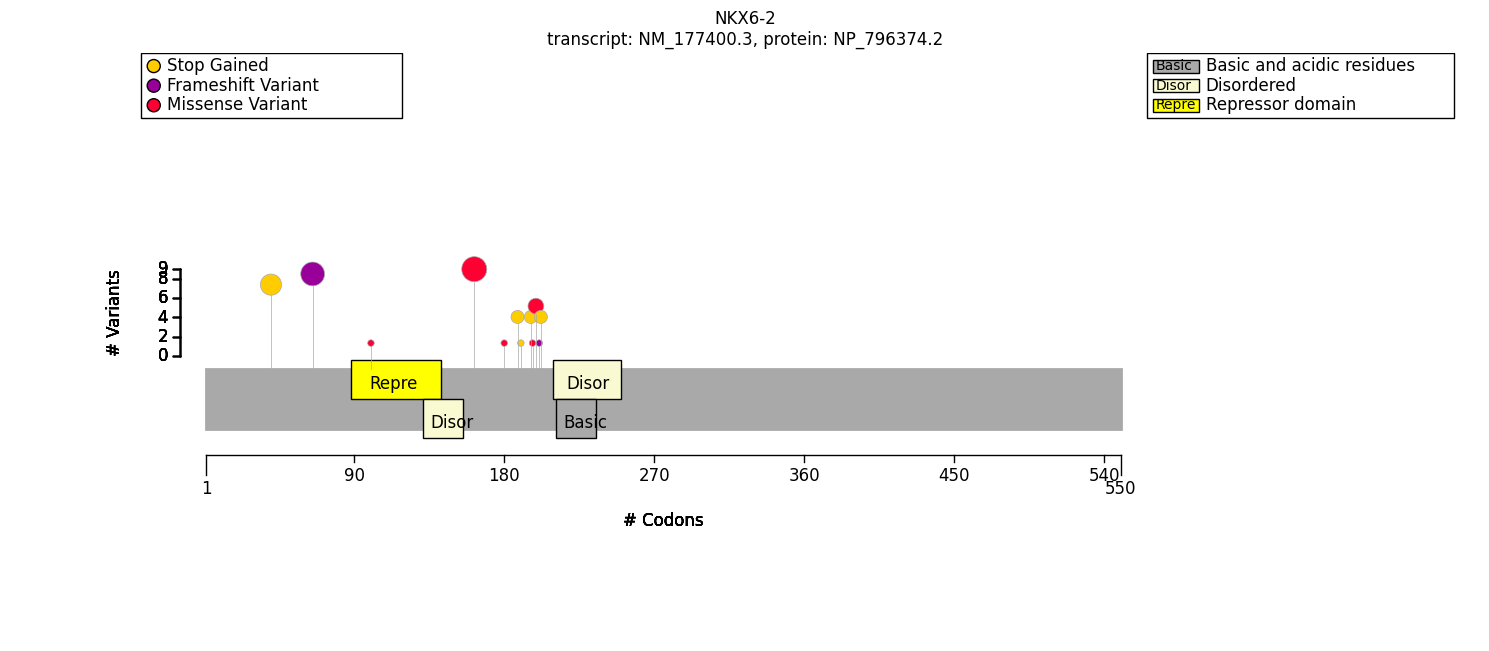

In [8]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

protein_meta = ProteinMetadata.from_uniprot_json(
        protein_id=mane_protein_id,
        label="NKX6-2",
        uniprot_json="Q9C056.json",
        protein_length=550,
)

fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

## Strategy
15 of the 33 variants are missense, with the rest being loss of function categories. Let us also test the region including the Repressor region and N-terminal to that, and the most commonly observed variants.

In [11]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, autosomal_dominant

abl_pred = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, mane_tx_id)
gt_predicate = autosomal_dominant(abl_pred)

In [12]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
from gpsea.analysis.pcats.stats import FisherExactTest
from gpsea.analysis.mtc_filter import HpoMtcFilter
from gpsea.analysis.pcats import HpoTermAnalysis

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

mtc_filter = HpoMtcFilter.default_filter(hpo=hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
statistic = FisherExactTest()

analysis = HpoTermAnalysis(
    count_statistic=statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=0.05,
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.2,5
HMF04,Skipping term because all genotypes have same HPO observed proportions,17
HMF05,Skipping term because one genotype had zero observations,3
HMF06,Skipping term with less than 7 observations (not powered for 2x2),66
HMF08,Skipping general term,33


In [13]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=result)

What is the genotype group              HOM_REF           HET          \
                                          Count Percent Count Percent   
Gingival overgrowth [HP:0000212]            4/6     67%   0/2      0%   
Cognitive impairment [HP:0100543]           3/8     38%   2/2    100%   
Scoliosis [HP:0002650]                     4/11     36%   0/3      0%   
Ataxia [HP:0001251]                        6/10     60%   1/1    100%   
Loss of ambulation [HP:0002505]            9/10     90%   1/1    100%   
Hypometric saccades [HP:0000571]           3/10     30%   0/1      0%   
Global developmental delay [HP:0001263]   13/19     68%   2/3     67%   
Hypotonia [HP:0001252]                     9/11     82%   3/3    100%   
Tube feeding [HP:0033454]                   3/8     38%   1/3     33%   

What is the genotype group                                            
                                        Corrected p values  p values  
Gingival overgrowth [HP:0000212]                       1.0  0.428571  
Cognitive impairment [HP:0100543]                      1.0  0.444444  
Scoliosis [HP:0002650]                                 1.0  0.505495  
Ataxia [HP:0001251]                                    1.0  1.000000  
Loss of ambulation [HP:0002505]                        1.0  1.000000  
Hypometric saccades [HP:0000571]                       1.0  1.000000  
Global developmental delay [HP:0001263]                1.0  1.000000  
Hypotonia [HP:0001252]                                 1.0  1.000000  
Tube feeding [HP:0033454]                              1.0  1.000000

In [20]:
from gpsea.analysis.predicate.genotype import VariantPredicates, autosomal_recessive
is_var_key = VariantPredicates.variant_key("10_132785372_132785372_G_C") # 	c.487C>G	p.Leu163Val	MISSENSE_VARIANT
gt_predicate.display_question()
gt_predicate = autosomal_recessive(is_var_key, partitions={(0,), (1,)})
gt_predicate.display_question()

'What is the genotype group: HOM_REF, HET'

In [21]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=result)

Empty DataFrame
Columns: [(HOM_REF, Count), (HOM_REF, Percent), (HET, Count), (HET, Percent), (, p values)]
Index: []

In [24]:
from gpsea.model.genome import Region
n_term = VariantPredicates.region(Region(0,160), tx_id=mane_tx_id)
gt_predicate = autosomal_recessive(n_term, partitions={(0,), (1,)})
gt_predicate.display_question()

'What is the genotype group: HOM_REF, HET'

In [25]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=result)

What is the genotype group              HOM_REF           HET          \
                                          Count Percent Count Percent   
Nystagmus [HP:0000639]                    17/17    100%   0/1      0%   
Global developmental delay [HP:0001263]   16/17     94%   0/1      0%   
Hypotonia [HP:0001252]                    14/17     82%   0/1      0%   
Seizure [HP:0001250]                        2/9     22%   1/1    100%   
Loss of ambulation [HP:0002505]             4/6     67%   0/1      0%   
Hypometric saccades [HP:0000571]            4/7     57%   0/1      0%   
Scoliosis [HP:0002650]                     5/12     42%   0/1      0%   
Tube feeding [HP:0033454]                  4/10     40%   0/1      0%   

What is the genotype group                                            
                                        Corrected p values  p values  
Nystagmus [HP:0000639]                            0.444444  0.055556  
Global developmental delay [HP:0001263]           0.444444  0.111111  
Hypotonia [HP:0001252]                            0.592593  0.222222  
Seizure [HP:0001250]                              0.600000  0.300000  
Loss of ambulation [HP:0002505]                   0.685714  0.428571  
Hypometric saccades [HP:0000571]                  1.000000  1.000000  
Scoliosis [HP:0002650]                            1.000000  1.000000  
Tube feeding [HP:0033454]                         1.000000  1.000000